In [ ]:
# Load the already trained models.
import tensorflow as tf
EfficientNet_loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/EfficientNet&Resnet_saved_models_without_fine_tuning/dataset_200sr_20tau")
Resnet_loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/EfficientNet&Resnet_saved_models_without_fine_tuning/ResNet/dataset_200sr_20tau")
Xception_loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Xception_saved_models/Xception_feature_extraction_without_fine_tuning_dataset_200sr_20tau_rescaling")

In [ ]:
# Prepare dataset
train_dir = "/content/drive/MyDrive/dataset_Transfer_learning(20tau)/dataset_200sr_20tau/training_set"
test_dir = "/content/drive/MyDrive/dataset_Transfer_learning(20tau)/dataset_200sr_20tau/testing_set"
group_validation_dataset_dir = "/content/drive/MyDrive/target_dataset_10_classes(Jasper)"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False)

group_validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(group_validation_dataset_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False) # don't shuffle test data for prediction analysis,such as f1 scores.

Found 600 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [ ]:
# Evaluate the loaded EfficientNet model and compare results with original results to make sure we loaded saved model successfully. 
loaded_models_results = EfficientNet_loaded_model.evaluate(test_data)
loaded_models_results

63/63 [==============================] - 231s 4s/step - loss: 0.3976 - accuracy: 0.9055


[0.3976230025291443, 0.9054999947547913]

In [ ]:
# Evaluate the loaded Resnet model and compare results with original results to make sure we loaded saved model successfully. 
loaded_models_results = Resnet_loaded_model.evaluate(test_data)
loaded_models_results

63/63 [==============================] - 9s 114ms/step - loss: 1.0095 - accuracy: 0.7890


[1.009507179260254, 0.7889999747276306]

In [ ]:
# Evaluate the loaded Xception model and compare results with original results to make sure we loaded saved model successfully. 
loaded_models_results = Xception_loaded_model.evaluate(test_data)
loaded_models_results

63/63 [==============================] - 12s 153ms/step - loss: 0.3749 - accuracy: 0.9180


[0.3749365210533142, 0.9179999828338623]

In [ ]:
# Make predictions with the EfficientNet model
EfficientNet_pred_probs = EfficientNet_loaded_model.predict(group_validation_dataset, verbose=1) # set verbosity to see how long it will take 

94/94 [==============================] - 395s 4s/step


In [ ]:
# Make predictions with the EfficientNet model
Resnet_pred_probs = Resnet_loaded_model.predict(group_validation_dataset, verbose=1) # set verbosity to see how long it will take 

94/94 [==============================] - 11s 106ms/step


In [ ]:
# Make predictions with the EfficientNet model
Xception_pred_probs = Xception_loaded_model.predict(group_validation_dataset, verbose=1) # set verbosity to see how long it will take 

94/94 [==============================] - 15s 149ms/step


In [ ]:
# Get the class predicitons of each label
EfficientNet_pred_classes = EfficientNet_pred_probs.argmax(axis=1)
Resnet_pred_classes = Resnet_pred_probs.argmax(axis=1)
Xception_pred_classes = Xception_pred_probs.argmax(axis=1)

In [ ]:
# Compare predictions of three models to choose the most possible results.
pred_classes = []
for i in range(len(EfficientNet_pred_classes)):
  count_pred_classes = [0]*len(group_validation_dataset.class_names)
  count_pred_classes[EfficientNet_pred_classes[i]] += 1
  count_pred_classes[Resnet_pred_classes[i]] += 1
  count_pred_classes[Xception_pred_classes[i]] += 1
  pred_classes.append(count_pred_classes.index(max(count_pred_classes)))

In [ ]:
# How do pred_classes look?
pred_classes[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 5, 0]

In [ ]:
# To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.
y_labels = []
for images, labels in group_validation_dataset.unbatch(): # unbatch the group validation dataset and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

3000

In [ ]:
# The following confusion matrix code is a remix of Scikit-Learn's plot_confusion_matrix function.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = group_validation_dataset.class_names
class_names

['flickers',
 'harmonics',
 'interruptions',
 'interruptions_harmonics',
 'osc_transients',
 'sags',
 'sags_harmonics',
 'spikes',
 'swells',
 'swells_harmonics']

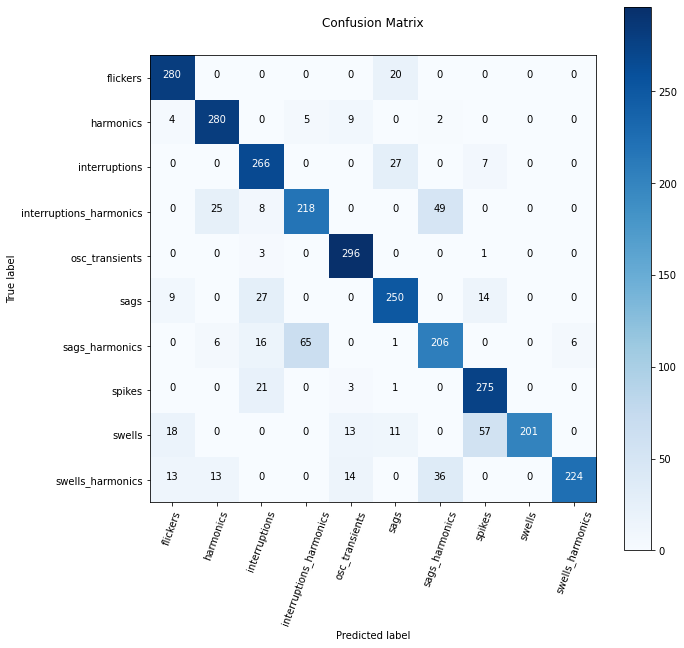

In [ ]:
# Plot a confusion matrix with all predictions, ground truth labels and 10 classes
make_confusion_matrix(y_true=y_labels,
          y_pred=pred_classes,
          classes=class_names,
          figsize=(10, 10),
          text_size=10,
          norm=False,
          savefig=True)

In [ ]:
# Print evaluation results of the model, including macro f1 scores.
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, digits = 3))

              precision    recall  f1-score   support

           0      0.864     0.933     0.897       300
           1      0.864     0.933     0.897       300
           2      0.780     0.887     0.830       300
           3      0.757     0.727     0.741       300
           4      0.884     0.987     0.932       300
           5      0.806     0.833     0.820       300
           6      0.703     0.687     0.695       300
           7      0.777     0.917     0.841       300
           8      1.000     0.670     0.802       300
           9      0.974     0.747     0.845       300

    accuracy                          0.832      3000
   macro avg      0.841     0.832     0.830      3000
weighted avg      0.841     0.832     0.830      3000

